In [29]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display
import numpy as np

import os
import time
import cmath

import keras
import keras.layers as layers
from keras import backend as K
from keras.utils import plot_model

import matplotlib.pyplot as plt
%matplotlib inline

TODO
* Look into saving frames to file

* Clean out cqt stuff 

* Automatic logging of graphs, errors, etc. for comparison
* Add graph of model
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
* Create log output function, then capture to text file (also export graphs?)

* Look for sources of noise that are close to what I want?  Or generate some clips?

* Currently bottom rows are zeroed out - should just remove them
* Debugging tools for comparing, listening to, and viewing clips
* Add audio quality comparisons between clean clips and cleaned clips for evaluation

* Add history error plotting to compare different learning models, topologies, etc.

* Why does https://towardsdatascience.com/audio-ai-isolating-vocals-from-stereo-music-using-convolutional-neural-networks-210532383785 only use real component?
* Evaluate different representations of complex numbers in terms of learnability

* Consider generating custom data for goal - male speakers, low voice, specific sounds

In [39]:
# Constants and settings
WINDOW_SIZE = 25  # Has to be odd
TARGET_COL = WINDOW_SIZE//2

# cqt related
FFT_BINS = 513 # function of items below
HOP_LENGTH = 512

# stft values
N_FFT = 1024 # 512 recommended for speech, music typically 2048

# cqt values
#BINS_PER_OCTAVE = 12 * 10
#FMIN = librosa.note_to_hz('C1')
#OCTAVES = 8

In [40]:
# Idea here is that we operate on magnitude, and will just use phase from the original noisy sample

def combine_target(t):
    return (t[0:t.shape[0]//2] + 1j * t[t.shape[0]//2:]).reshape(1,(t.shape[0]//2))

def rebuild_fft(output, original_fft):
    vphase = np.vectorize(cmath.phase)
    o_phase = vphase(original_fft)
    mag = output.T
    vrect = np.vectorize(cmath.rect)
    return vrect(mag, o_phase)
    
# build up as (bins, samples) then transpose to model view of (samples, bins)
def targets_to_fft(targets):
    fft = np.empty((targets.shape[0],targets.shape[1]//2), dtype='complex64')
    for i in range(0, targets.shape[0]):
        fft[i] = combine_target(targets[i])
    return fft.T   # transpose

def get_ft(wav):
    #c = librosa.cqt(wav, hop_length=HOP_LENGTH, fmin=FMIN, n_bins=OCTAVES*BINS_PER_OCTAVE, bins_per_octave=BINS_PER_OCTAVE)
    c = librosa.stft(wav, hop_length=HOP_LENGTH, n_fft=N_FFT)
    return c

def inv_ft(ft):
    #return librosa.icqt(ft, hop_length=HOP_LENGTH, bins_per_octave=BINS_PER_OCTAVE)
    return librosa.istft(ft, hop_length=HOP_LENGTH)
    

In [41]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
fft = get_ft(wav)
print(fft.shape)

(513, 120)


(120, 513, 25, 1)
(120, 513)
0.002826246665790677
[0.00282625]
(513, 120)


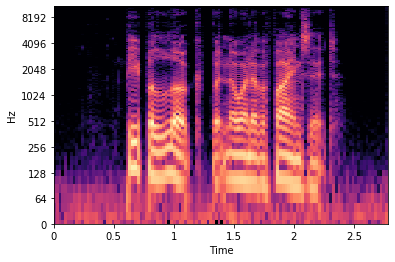

In [42]:
ft = clip_frames(test_file)
tt = clip_targets(test_file)

print(ft.shape)
print(tt.shape)

#Frame / target check  -  don't use first row because it might be zeroed out
r = 10
print(tt[0,r])
print(ft[0,r,TARGET_COL:TARGET_COL+1,0])

# Round trip test
new_fft = rebuild_fft(tt, fft)
print(new_fft.shape)
new_wav = inv_ft(new_fft)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

Audio(new_wav,rate=22050)

In [43]:
# Creating data from clip wave file
# Optimization - does frames for each clip in preallocated array
# output is (samples, bins, window size, layers), where image is depth 2 for real & imaginary
def clip_frames(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = get_ft(wav) # organized as bins, frames
    bins = fft.shape[0]
    pad = np.zeros((bins,frame_lead))
    frames = np.empty(shape=(fft.shape[1],bins,WINDOW_SIZE,1)) 
    fft = np.concatenate([pad, fft, pad], axis=-1)
    for i in range(0, fft.shape[1] - WINDOW_SIZE + 1):
        frames[i,:,:,0] = abs(fft[:,i:i+WINDOW_SIZE])
    return frames

# output is array (samples, double bin length made up of real then imag)
def clip_targets(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = get_ft(wav)
    bins = fft.shape[0]
    targets = np.empty(shape=(fft.shape[1],fft.shape[0]))
    for i in range(0, fft.shape[1]):
        targets[i,:] = abs(fft[:,i:i+1]).flatten()
    return targets

In [44]:
# Iterate over clean & noisy folders to create frames and targets
def create_data(root, max_files = 50):
    clean_dir = root + "\\Clean\\"
    noisy_dir = root + "\\Noisy\\"
    frames = np.empty(shape=(0,FFT_BINS,WINDOW_SIZE,1))
    targets = np.empty(shape=(0,FFT_BINS))
    i = 0
    start = time.time()
    check = time.time()
    for file in os.listdir(clean_dir)[0:max_files]:
        i += 1
        if i % 50 == 0:
            print("{0} clips   total {1:.0f}   last cycle {2:.0f}".format(i, time.time() - start,time.time()-check))
            check = time.time()
        filename = os.fsdecode(file)
        frames = np.concatenate((frames,clip_frames(noisy_dir + file)), axis=0)
        targets = np.concatenate((targets,clip_targets(clean_dir + file)), axis=0)
    return frames, targets


In [55]:
frames, targets = create_data("Assets\\DataShareArchive\\Test", 200)

50 clips   total 20   last cycle 20
100 clips   total 45   last cycle 24
150 clips   total 77   last cycle 32
200 clips   total 116   last cycle 39


In [48]:
# Real model (eventually)

inputs = layers.Input(shape=(FFT_BINS,WINDOW_SIZE,1)) # Full window
input_slice = layers.Input(shape=(FFT_BINS,1,1)) # Just the center row that we're trying to predict
conv1 = layers.Conv2D(32, kernel_size=(5,3), activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', 
                      input_shape=[FFT_BINS,WINDOW_SIZE,2])(inputs)
conv2 = layers.Conv2D(32, kernel_size=(5,3), activation=keras.layers.LeakyReLU(alpha=0.3))(conv1) 
pool1 = layers.MaxPooling2D(pool_size=(3,3))(conv2)
conv3 = layers.Conv2D(32, kernel_size=(5,3), activation=keras.layers.LeakyReLU(alpha=0.3))(pool1) 
pool2 = layers.MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = layers.Conv2D(32, kernel_size=1, activation=keras.layers.LeakyReLU(alpha=0.3))(pool2) # Seems like making this too big causes OOM
flat = layers.Flatten()(conv4)
dense0 = layers.Dense(1000, activation=keras.layers.LeakyReLU(alpha=0.3))(flat)
dense1 = layers.Dense(750, activation=keras.layers.LeakyReLU(alpha=0.3))(dense0)
dense2 = layers.Dense(500, activation=keras.layers.LeakyReLU(alpha=0.3))(dense1)
flat_in = layers.Flatten()(input_slice)
merged = layers.concatenate([dense2, flat_in])
outputs = layers.Dense(FFT_BINS, activation='linear')(merged)

model = keras.models.Model(inputs=[inputs,input_slice], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 513, 25, 1)   0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 509, 23, 32)  512         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 505, 21, 32)  15392       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 168, 7, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (

In [66]:
hist = model.fit([frames, frames[:,:,TARGET_COL:TARGET_COL+1,:]], targets, epochs=100, batch_size=32, validation_split=0.05)

Train on 21698 samples, validate on 1143 samples
Epoch 1/100
21698/21698 [==============================] - 48s 2ms/step - loss: 0.0301 - val_loss: 0.0427
Epoch 2/100
21698/21698 [==============================] - 48s 2ms/step - loss: 0.0285 - val_loss: 0.0551
Epoch 3/100
21698/21698 [==============================] - 48s 2ms/step - loss: 0.0287 - val_loss: 0.0439
Epoch 4/100
21698/21698 [==============================] - 48s 2ms/step - loss: 0.0257 - val_loss: 0.0420
Epoch 5/100
21698/21698 [==============================] - 48s 2ms/step - loss: 0.0256 - val_loss: 0.0404
Epoch 6/100
21698/21698 [==============================] - 48s 2ms/step - loss: 0.0245 - val_loss: 0.0457
Epoch 7/100
21698/21698 [==============================] - 48s 2ms/step - loss: 0.0239 - val_loss: 0.0458
Epoch 8/100
21698/21698 [==============================] - 48s 2ms/step - loss: 0.0240 - val_loss: 0.0420
Epoch 9/100
21698/21698 [==============================] - 48s 2ms/step - loss: 0.0220 - val_loss: 0.04

21698/21698 [==============================] - 47s 2ms/step - loss: 0.0097 - val_loss: 0.0399
Epoch 78/100
21698/21698 [==============================] - 47s 2ms/step - loss: 0.0097 - val_loss: 0.0415
Epoch 79/100
21698/21698 [==============================] - 47s 2ms/step - loss: 0.0113 - val_loss: 0.0404
Epoch 80/100
21698/21698 [==============================] - 47s 2ms/step - loss: 0.0101 - val_loss: 0.0445
Epoch 81/100
21698/21698 [==============================] - 47s 2ms/step - loss: 0.0094 - val_loss: 0.0402
Epoch 82/100
21698/21698 [==============================] - 47s 2ms/step - loss: 0.0101 - val_loss: 0.0409
Epoch 83/100
21698/21698 [==============================] - 47s 2ms/step - loss: 0.0095 - val_loss: 0.0425
Epoch 84/100
21698/21698 [==============================] - 47s 2ms/step - loss: 0.0099 - val_loss: 0.0425
Epoch 85/100
21698/21698 [==============================] - 47s 2ms/step - loss: 0.0114 - val_loss: 0.0423
Epoch 86/100
21698/21698 [========================

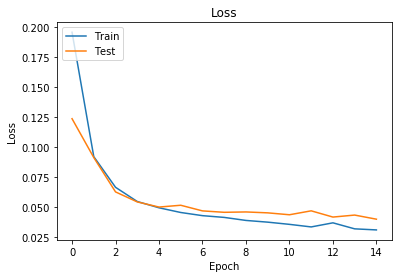

Validation loss mean 5+ epochs 0.04529
Clips  22841


In [57]:

history = hist

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.ylim((0, history.history['loss'][0])) 
plt.show()

#plt.savefig('test.png')
print("Validation loss mean 5+ epochs {0:.4}".format(np.mean(history.history['val_loss'][5:])))
print("Clips ", frames.shape[0])

#Add verification means for 1-10, 11-20, 21-30?  Or slope for different ranges?

Error total  -829.6315134819275  over  102087  =  -0.008126710682867824


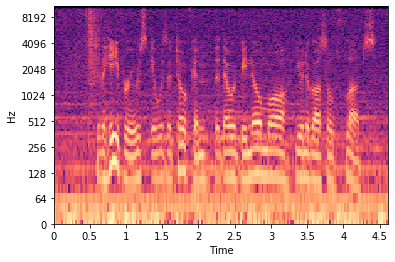

In [73]:
# Full round trip test

verify_file = "Assets\\DataShareArchive\\Test\\Noisy\\p232_014.wav"
clean_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_014.wav"
verify_frames = clip_frames(verify_file)
verify_targets = clip_targets(verify_file)
clean_targets = clip_targets(clean_file)

output_targets = model.predict([verify_frames, verify_frames[:,:,TARGET_COL:TARGET_COL+1,:]])

err = clean_targets - output_targets
print("Error total ", np.sum(err), " over ", err.shape[0] * err.shape[1], " = ", np.sum(err)/(err.shape[0] * err.shape[1]))


#p_fft = targets_to_fft(output_targets)
#p_fft = targets_to_fft(verify_targets)
wav, rate = librosa.core.load(verify_file)
fft = get_ft(wav)
p_fft = rebuild_fft(output_targets, fft)


def display_fft(ft):
    #librosa.display.specshow(librosa.amplitude_to_db(np.abs(ft), ref=np.max), y_axis='cqt_note', x_axis='time', hop_length=HOP_LENGTH, fmin=FMIN,  bins_per_octave=BINS_PER_OCTAVE)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

display_fft(p_fft)
p_wav = inv_ft(p_fft)
Audio(p_wav,rate=22050)


In [74]:
Audio(wav, rate=rate)

In [ ]:
#%%capture cap
print(model.summary())
#with open('output.txt', 'w') as f:
#    f.write(cap.stdout)


In [ ]:
fresh_wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\Noisy\\p232_019.wav")
Audio(fresh_wav, rate=rate)

Test & reference stuff 

In [ ]:
    
def show_fft(wav):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max), y_axis='log', x_axis='time')

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

print(new_fft.shape)

#show_fft(wav)
#show_fft(new_wav)
#Audio(wav, rate=22050)


In [ ]:
# Test stuff for hacking around    
    
a = np.array([[1+2j, 3+4j, 1.5+2.5j],[5+6j,7+8j, 5.5+6.5j]])
print(a)
a1 = a[0]
print(a1)
ar = a1.real
ai = a1.imag

st = np.zeros((6))
st[0:3] = ar
st[3:6] = ai
print(ar.shape, ai.shape, st.shape)
print(ar, ai)
print(st)


In [ ]:
# ''do nothing' model that should be able to guess outputs from outputs

inputs = layers.Input(shape=(FFT_BINS*2,))
dense1 = layers.Dense(2000, activation='relu')(inputs)
dense2 = layers.Dense(2000, activation='relu')(dense1)
#flat = layers.Flatten()(dense)
#flat_in = layers.Flatten()(inputs)
#merged = layers.concatenate([flat, flat_in])
merged = layers.concatenate([dense2, inputs])
linear = layers.Dense(2000, activation='linear')(merged)
outputs = layers.Dense(2*FFT_BINS, activation='linear')(linear)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

model.fit(targets, targets, epochs=1, batch_size=32)